In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!nvidia-smi

Tue Jul  4 12:51:52 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D,Lambda, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore',category=FutureWarning)
%matplotlib inline


In [4]:
print(tf.config.experimental.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [6]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [7]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [8]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)
tf.config.experimental.set_memory_growth(physical_devices[0], True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [9]:
train_path='/content/drive/MyDrive/fabric_inspection/Dataset/train'
valid_path='/content/drive/MyDrive/fabric_inspection/Dataset/val'
test_path='/content/drive/MyDrive/fabric_inspection/Dataset/test'

In [10]:
classes=['Fabric_DirtySpot', 'Fabric_DyeSpot', 'Fabric_Fresh', 'Fabric_Hole', 'Fabric_LycraMiss', 'Fabric_NiddleBroken', 'Fabric_OilSpot', 'Fabric_Patta', 'Fabric_YarnContamination']

In [11]:
train_batch=ImageDataGenerator( preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
 .flow_from_directory(train_path,target_size=(224,224), classes=classes,batch_size=10)

valid_batch=ImageDataGenerator(  preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
 .flow_from_directory(valid_path,target_size=(224,224), classes=classes,batch_size=10)


test_batch=ImageDataGenerator(  preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
 .flow_from_directory(test_path,target_size=(224,224), classes=classes,batch_size=10,shuffle=False)

Found 3315 images belonging to 9 classes.
Found 1764 images belonging to 9 classes.
Found 1490 images belonging to 9 classes.


In [12]:
imgs, labels=next(train_batch)

In [13]:
def plotImages(images_arr):
  fig,axes=plt.subplots(1,10,figsize=(20,20))
  axes=axes.flatten()
  for img, ax in zip(images_arr,axes):
    ax.imshow(img)
    ax.axis('off')
  plt.tight_layout()
  plt.show()

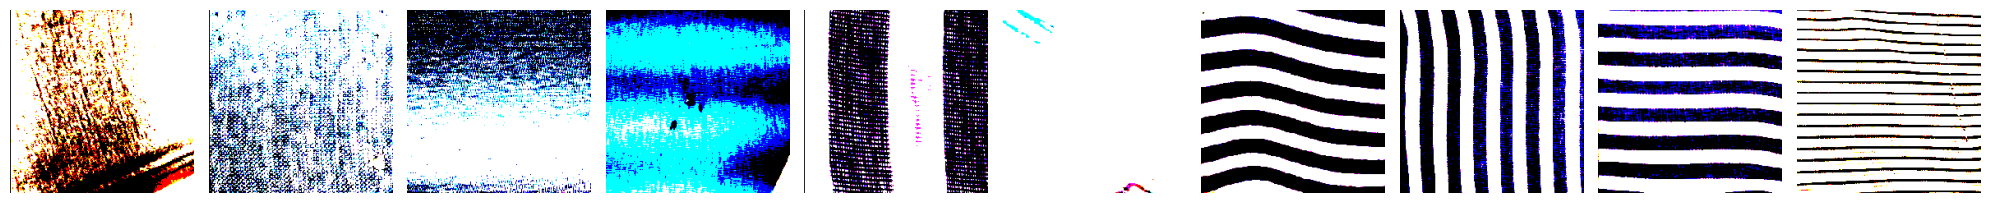

[[0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]]


In [14]:
plotImages(imgs)
print(labels)

In [15]:
from keras.layers import Input, Lambda, Dense, Flatten, Dropout
from keras.models import Model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

resnet50 = tf.keras.applications.ResNet50(input_shape=[224,224,3], weights='imagenet', include_top=False)

for layer in resnet50.layers:
  layer.trainable = False

x = Flatten()(resnet50.output)

predictionLayer = Dense(9, activation='softmax')(x)

model_resnet50 = Model(inputs=resnet50.input, outputs=predictionLayer)

94765736/94765736 [==============================] - 5s 0us/step


In [16]:
model_resnet50.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [17]:
class MyThresholdCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(MyThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
      val_acc = logs["accuracy"]
      if val_acc >= self.threshold:
        self.model.stop_training = True



In [18]:
callback=MyThresholdCallback(threshold=1.0)

In [19]:
model_resnet50.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

In [20]:
h_16=model_resnet50.fit(x=train_batch, validation_data=valid_batch, epochs=30, verbose=2,callbacks=[callback])

Epoch 1/30
332/332 - 2929s - loss: 0.5617 - accuracy: 0.8516 - val_loss: 0.1195 - val_accuracy: 0.9688 - 2929s/epoch - 9s/step
Epoch 2/30
332/332 - 29s - loss: 0.0832 - accuracy: 0.9807 - val_loss: 0.1347 - val_accuracy: 0.9717 - 29s/epoch - 88ms/step
Epoch 3/30
332/332 - 28s - loss: 0.0600 - accuracy: 0.9858 - val_loss: 0.0857 - val_accuracy: 0.9819 - 28s/epoch - 84ms/step
Epoch 4/30
332/332 - 28s - loss: 0.0337 - accuracy: 0.9931 - val_loss: 0.0520 - val_accuracy: 0.9875 - 28s/epoch - 83ms/step
Epoch 5/30
332/332 - 28s - loss: 0.0360 - accuracy: 0.9922 - val_loss: 0.0536 - val_accuracy: 0.9881 - 28s/epoch - 84ms/step
Epoch 6/30
332/332 - 28s - loss: 0.0304 - accuracy: 0.9934 - val_loss: 0.1076 - val_accuracy: 0.9700 - 28s/epoch - 83ms/step
Epoch 7/30
332/332 - 27s - loss: 0.0830 - accuracy: 0.9783 - val_loss: 0.0604 - val_accuracy: 0.9830 - 27s/epoch - 82ms/step
Epoch 8/30
332/332 - 27s - loss: 0.0573 - accuracy: 0.9879 - val_loss: 0.0499 - val_accuracy: 0.9898 - 27s/epoch - 83ms/ste

In [21]:
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, log_loss ,accuracy_score
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, roc_auc_score , auc
import numpy as np
predictions=model_resnet50.predict(x=test_batch,verbose=0)
print('Confusion matrix is :')
cm = confusion_matrix(y_true=test_batch.classes,y_pred=np.argmax(predictions,axis=1))
TP = cm[0][0]
TN = cm[1][1]
FP = cm[0][1]
FN = cm[1][0]
print(cm)
print()
classificationReport = classification_report(y_true=test_batch.classes,y_pred=np.argmax(predictions,axis=1))
print("Classification Report : ")
print (classificationReport)
print("\n")
print('Testing accuracy : ',accuracy_score(y_true=test_batch.classes,y_pred=np.argmax(predictions,axis=1)))
print("F1 Score :",f1_score(y_true=test_batch.classes,y_pred=np.argmax(predictions,axis=1),average='macro'))
print("Precision :", precision_score(y_true=test_batch.classes,y_pred=np.argmax(predictions,axis=1),average='macro'))
print("Recall :", recall_score(y_true=test_batch.classes,y_pred=np.argmax(predictions,axis=1),average='macro'))
print('Sensitivity : ', TP/(TP+FN))
print('Specificity : ', TN/(TN+FP))
print('false positive rate : ', FP/(FP+TN))
print('false negative rate : ', FN/(FN+TP))
print('Negative Predictive Value : ', TN/(TN+FN))
print('False Discovery rate : ', FP/(TP+FP))

Confusion matrix is :
[[106   0   0   0   0   0   0   0   0]
 [  0 227   0   0   0   0   0   0   0]
 [  0   0  83   5   0   0   0   0   0]
 [  0   0   0 343   0   0   0   0   0]
 [  0   0   0   0 148   0   0   0   0]
 [  0   0   0   1   0  37   0   0   0]
 [  0   1   0   1   0   1 188   0   0]
 [  0   0   0   0   0   0   0 174   0]
 [  0   0   0   0   0   0   0   0 175]]

Classification Report : 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       106
           1       1.00      1.00      1.00       227
           2       1.00      0.94      0.97        88
           3       0.98      1.00      0.99       343
           4       1.00      1.00      1.00       148
           5       0.97      0.97      0.97        38
           6       1.00      0.98      0.99       191
           7       1.00      1.00      1.00       174
           8       1.00      1.00      1.00       175

    accuracy                           0.99      1490
   m

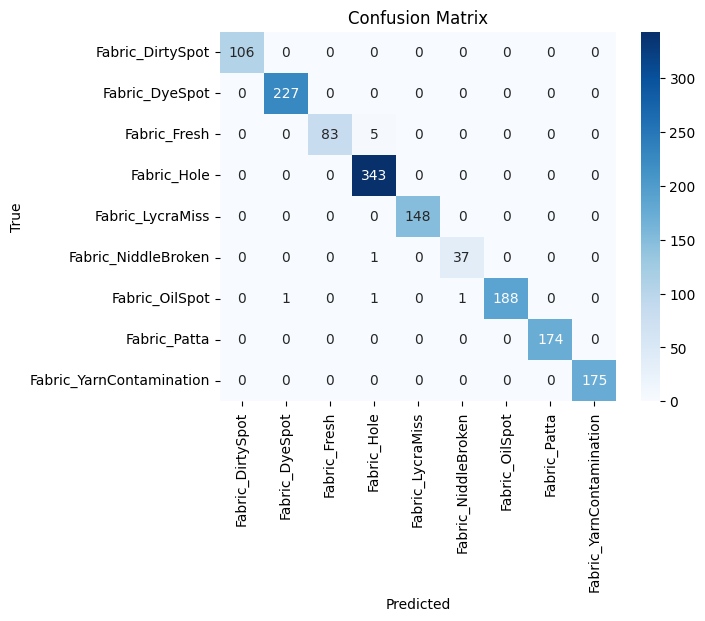

Sensitivity: 1.0
Specificity: 1.0
False positive rate: 0.0
False negative rate: 0.0
Negative Predictive Value: 1.0
False Discovery rate: 0.0


In [22]:
import seaborn as sns
class_labels = list(test_batch.class_indices.keys())
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print('Sensitivity:', TP / (TP + FN))
print('Specificity:', TN / (TN + FP))
print('False positive rate:', FP / (FP + TN))
print('False negative rate:', FN / (FN + TP))
print('Negative Predictive Value:', TN / (TN + FN))
print('False Discovery rate:', FP / (TP + FP))

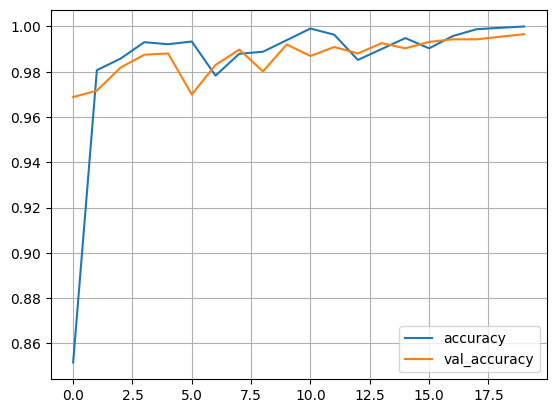

In [23]:
# visualisation of accuracy
import matplotlib.pyplot as plt
plt.plot(h_16.history['accuracy'], label = 'accuracy')
plt.plot(h_16.history['val_accuracy'], label = 'val_accuracy')
plt.grid()
plt.legend()
plt.show()

In [24]:
cnf_matrix=cm
FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)
FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
TP = np.diag(cnf_matrix)
TN = cnf_matrix.sum() - (FP + FN + TP)
FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)
# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
print('Sensitivity : ', TPR)

# Specificity or true negative rate
TNR = TN/(TN+FP)
print('Specificity : ', TNR)
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)
# Overall accuracy for each class
ACC = (TP+TN)/(TP+FP+FN+TN)
print("ACC",ACC)

Sensitivity :  [1.         1.         0.94318182 1.         1.         0.97368421
 0.98429319 1.         1.        ]
Specificity :  [1.         0.99920823 1.         0.99389712 1.         0.99931129
 1.         1.         1.        ]
ACC [1.         0.99932886 0.9966443  0.99530201 1.         0.99865772
 0.99798658 1.         1.        ]


In [ ]:
model_resnet50